# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"><img src="../images/icon102.png" width="38px"></img> **Hopsworks Feature Store** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
from functions import util

/home/jdowling/anaconda3/envs/book/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Getting the current date
today = datetime.date.today()
# start_day = today - datetime.timedelta(days = 100)
country="sweden"
city="stockholm"
street="stockholm-hornsgatan-108-gata"

## <span style="color:#ff5f27;"> 📡 Connecting to Hopsworks Feature Store </span>

In [3]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://snurran.hops.works:443/p/5240
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [4]:
# Retrieve the 'air_quality_fv' feature view
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=5,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

External IP not configured for the Istio ingress gateway, the Hopsworks client will be used for model inference instead
Connected. Call `.close()` to terminate connection gracefully.


In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.5548958E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [7]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

f = weather_fg.read()

Finished: Reading data from Hopsworks, using ArrowFlight (0.73s) 


In [8]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
a = air_quality_fg.read()
a = a.sort_values(by=['date'])
a

Finished: Reading data from Hopsworks, using ArrowFlight (0.77s) 


,date,pm25,country,city,street
1465,2017-10-04 00:00:00+00:00,13.0,sweden,stockholm,stockholm-hornsgatan-108-gata
1076,2017-10-05 00:00:00+00:00,9.0,sweden,stockholm,stockholm-hornsgatan-108-gata
1917,2017-10-06 00:00:00+00:00,8.0,sweden,stockholm,stockholm-hornsgatan-108-gata
1941,2017-10-07 00:00:00+00:00,13.0,sweden,stockholm,stockholm-hornsgatan-108-gata
1355,2017-10-08 00:00:00+00:00,8.0,sweden,stockholm,stockholm-hornsgatan-108-gata
...,...,...,...,...,...
2270,2024-03-06 00:00:00+00:00,44.0,sweden,stockholm,stockholm-hornsgatan-108-gata
2271,2024-03-07 00:00:00+00:00,54.0,sweden,stockholm,stockholm-hornsgatan-108-gata
2272,2024-03-08 00:00:00+00:00,41.0,sweden,stockholm,stockholm-hornsgatan-108-gata
2273,2024-03-09 00:00:00+00:00,35.0,sweden,stockholm,stockholm-hornsgatan-108-gata


In [9]:
batch_data = f[f['date'] >= str(today)]
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
2349,2024-03-10 00:00:00+00:00,0.50,0.0,15.790833,114.227737,stockholm
2342,2024-03-11 00:00:00+00:00,3.15,0.0,12.522619,108.435043,stockholm
2345,2024-03-12 00:00:00+00:00,5.50,0.0,8.396570,120.963692,stockholm
2351,2024-03-13 00:00:00+00:00,6.15,0.0,12.538134,230.826355,stockholm
2352,2024-03-14 00:00:00+00:00,10.25,0.0,26.141552,247.319397,stockholm
2354,2024-03-15 00:00:00+00:00,7.45,0.1,8.496305,216.384445,stockholm
2355,2024-03-16 00:00:00+00:00,10.25,0.2,15.617529,205.974335,stockholm
2356,2024-03-17 00:00:00+00:00,1.70,0.1,16.946787,347.735229,stockholm
2357,2024-03-18 00:00:00+00:00,-0.80,0.5,16.595179,65.658920,stockholm
2358,2024-03-19 00:00:00+00:00,1.40,0.0,9.000000,163.739716,stockholm


In [10]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 2349 to 2358
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         10 non-null     datetime64[us, UTC]
 1   temperature_2m_mean          10 non-null     float32            
 2   precipitation_sum            10 non-null     float32            
 3   wind_speed_10m_max           10 non-null     float32            
 4   wind_direction_10m_dominant  10 non-null     float32            
 5   city                         10 non-null     object             
dtypes: datetime64[us, UTC](1), float32(4), object(1)
memory usage: 400.0+ bytes


In [11]:
# batch_data = feature_view.get_batch_data(start_time=today, event_time=True, primary_key=True)
# pred_df = batch_data.drop(columns=['date'])
# print(feature_view.query.to_string())

### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [12]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
2349,2024-03-10 00:00:00+00:00,0.50,0.0,15.790833,114.227737,stockholm,36.469070
2342,2024-03-11 00:00:00+00:00,3.15,0.0,12.522619,108.435043,stockholm,41.919151
2345,2024-03-12 00:00:00+00:00,5.50,0.0,8.396570,120.963692,stockholm,33.936745
2351,2024-03-13 00:00:00+00:00,6.15,0.0,12.538134,230.826355,stockholm,28.174686
2352,2024-03-14 00:00:00+00:00,10.25,0.0,26.141552,247.319397,stockholm,19.222097
2354,2024-03-15 00:00:00+00:00,7.45,0.1,8.496305,216.384445,stockholm,28.358477
2355,2024-03-16 00:00:00+00:00,10.25,0.2,15.617529,205.974335,stockholm,30.940536
2356,2024-03-17 00:00:00+00:00,1.70,0.1,16.946787,347.735229,stockholm,14.955661
2357,2024-03-18 00:00:00+00:00,-0.80,0.5,16.595179,65.658920,stockholm,40.948795
2358,2024-03-19 00:00:00+00:00,1.40,0.0,9.000000,163.739716,stockholm,46.445450


In [13]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 2349 to 2358
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         10 non-null     datetime64[us, UTC]
 1   temperature_2m_mean          10 non-null     float32            
 2   precipitation_sum            10 non-null     float32            
 3   wind_speed_10m_max           10 non-null     float32            
 4   wind_direction_10m_dominant  10 non-null     float32            
 5   city                         10 non-null     object             
 6   predicted_pm25               10 non-null     float32            
dtypes: datetime64[us, UTC](1), float32(5), object(1)
memory usage: 440.0+ bytes


In [14]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)

In [15]:
batch_data[['date', 'predicted_pm25']]

,date,predicted_pm25
2349,2024-03-10 00:00:00+00:00,36.469070
2342,2024-03-11 00:00:00+00:00,41.919151
2345,2024-03-12 00:00:00+00:00,33.936745
2351,2024-03-13 00:00:00+00:00,28.174686
2352,2024-03-14 00:00:00+00:00,19.222097
2354,2024-03-15 00:00:00+00:00,28.358477
2355,2024-03-16 00:00:00+00:00,30.940536
2356,2024-03-17 00:00:00+00:00,14.955661
2357,2024-03-18 00:00:00+00:00,40.948795
2358,2024-03-19 00:00:00+00:00,46.445450


In [16]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 2349 to 2358
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         10 non-null     datetime64[us, UTC]
 1   temperature_2m_mean          10 non-null     float32            
 2   precipitation_sum            10 non-null     float32            
 3   wind_speed_10m_max           10 non-null     float32            
 4   wind_direction_10m_dominant  10 non-null     float32            
 5   city                         10 non-null     object             
 6   predicted_pm25               10 non-null     float32            
 7   street                       10 non-null     object             
 8   country                      10 non-null     object             
 9   days_before_forecast_day     10 non-null     int64              
dtypes: datetime64[us, UTC](1), float32(5), int64(1), obj

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

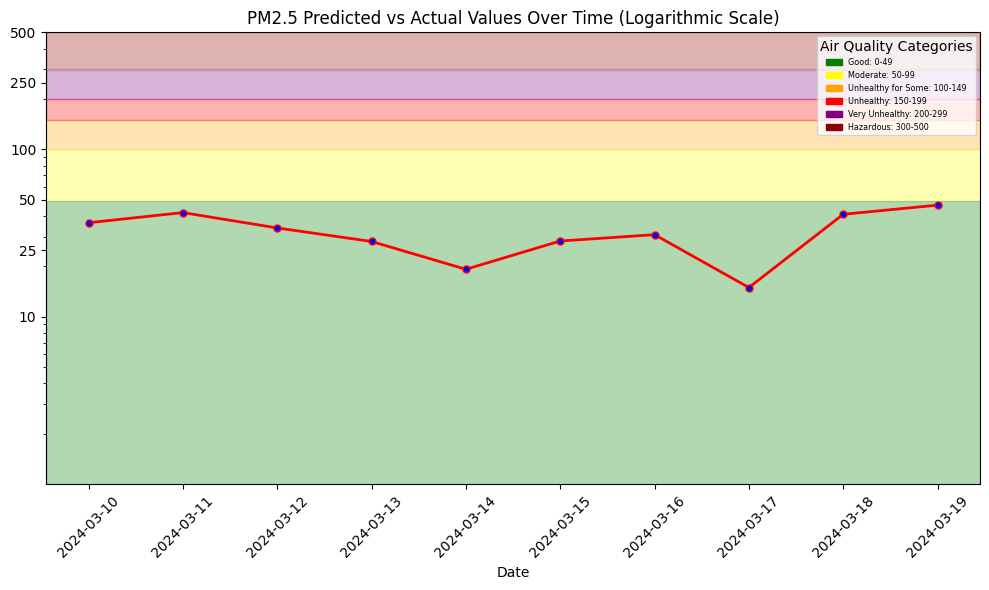

In [17]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(batch_data, file_path)
plt.show()

In [18]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_monitoring',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['country','street','date', 'days_before_forecast_day'],
    event_time="date"
)

In [19]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |███████████████████████████████████████████████████████████████████████████████| Rows 10/10 | Elapsed Time: 00:03 | Remaining Time: 00:00


Launching job: aq_monitoring_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://snurran.hops.works/p/5240/jobs/named/aq_monitoring_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7f0160757760>, None)

In [20]:
from hsfs.feature import Feature

# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(Feature("days_before_forecast_day") == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using ArrowFlight (0.76s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-03-09 00:00:00+00:00,0.7,0.0,10.495713,59.036320,stockholm,35.458157,stockholm-hornsgatan-108-gata,sweden,1
1,2024-03-10 00:00:00+00:00,0.5,0.0,15.790833,114.227737,stockholm,36.469070,stockholm-hornsgatan-108-gata,sweden,1


In [21]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using ArrowFlight (0.72s) 


,date,pm25,country,city,street
0,2017-10-18 00:00:00+00:00,10.0,sweden,stockholm,stockholm-hornsgatan-108-gata
1,2020-06-17 00:00:00+00:00,30.0,sweden,stockholm,stockholm-hornsgatan-108-gata
2,2023-04-12 00:00:00+00:00,62.0,sweden,stockholm,stockholm-hornsgatan-108-gata
3,2020-03-22 00:00:00+00:00,16.0,sweden,stockholm,stockholm-hornsgatan-108-gata
4,2018-11-11 00:00:00+00:00,57.0,sweden,stockholm,stockholm-hornsgatan-108-gata
...,...,...,...,...,...
2270,2024-03-06 00:00:00+00:00,44.0,sweden,stockholm,stockholm-hornsgatan-108-gata
2271,2024-03-07 00:00:00+00:00,54.0,sweden,stockholm,stockholm-hornsgatan-108-gata
2272,2024-03-08 00:00:00+00:00,41.0,sweden,stockholm,stockholm-hornsgatan-108-gata
2273,2024-03-09 00:00:00+00:00,35.0,sweden,stockholm,stockholm-hornsgatan-108-gata


In [22]:
air_quality_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2275 entries, 0 to 2274
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype              
---  ------   --------------  -----              
 0   date     2275 non-null   datetime64[us, UTC]
 1   pm25     2275 non-null   float32            
 2   country  2275 non-null   object             
 3   city     2275 non-null   object             
 4   street   2275 non-null   object             
dtypes: datetime64[us, UTC](1), float32(1), object(3)
memory usage: 80.1+ KB


In [23]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])
hindcast_df

,date,predicted_pm25,pm25
0,2024-03-09 00:00:00+00:00,35.458157,35.0
1,2024-03-10 00:00:00+00:00,36.469070,24.0


In [24]:
# import plotly.express as px

# fig = px.line(hindcast_df, x="date", y=['pm25', 'predicted_pm25'])
# filename = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
# fig.write_image(filename)

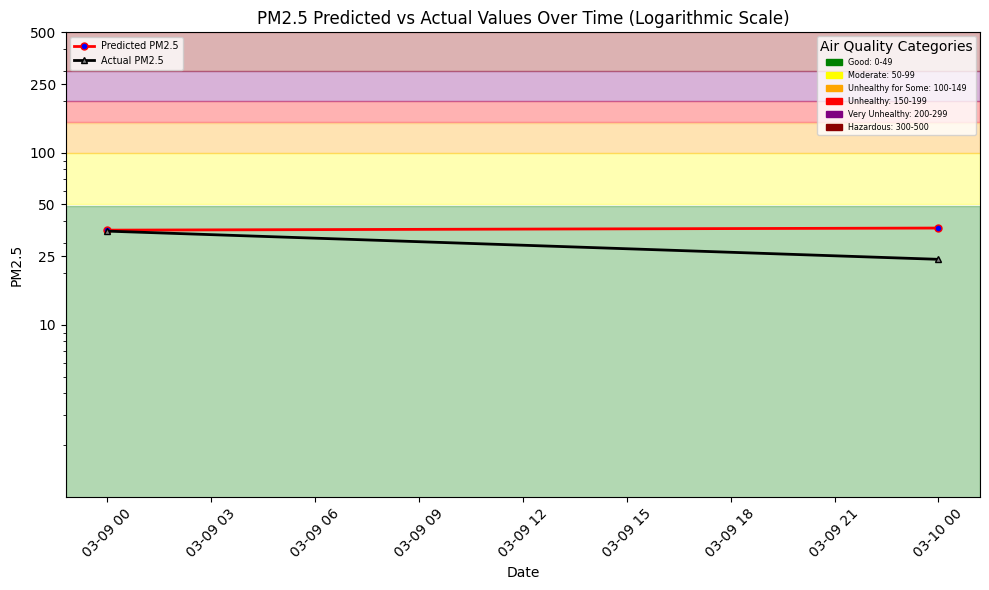

In [25]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(hindcast_df, file_path, hindcast=True)
plt.show()